In [4]:
import os
import torch
import matplotlib.pyplot as plt

We generated convergence maps with the default `sbi_lens` settings and stored them in `/data/scratch/convergence_maps/lsst_y10_lognormal`. The default `sbi_lens` settings are meant to emulate year 10 of LSST. The maps are of size 256x256x5, where 5 is the number of redshift bins.

Below, we load 1000 batches of 16 maps. Loading more batches is possible but takes a while. We also load the six cosmological parameters that generated them:

- $\Omega_c$: Amount of cold dark matter
- $\Omega_b$: Amount of baryonic matter
- $\sigma_8$: Clumpiness of matter
- $h_0$: How fast the Universe is expanding right now
- $n_s$: Variation in matter clumpiness at different scales in the early Universe
- $w_0$: Strength with which dark energy causes the Universe to expand

In [5]:
path = "/data/scratch/convergence_maps/lsst_y10_lognormal/"

num_batches_to_load = 1000  # there are around 6000 in total
batch_size = 16

maps = torch.zeros(num_batches_to_load * batch_size, 256, 256, 5)
params = torch.zeros(num_batches_to_load * batch_size, 6)

# this loop takes approximately 30 seconds
for i, f in enumerate(os.listdir(path)[:num_batches_to_load]):
    file = torch.load(os.path.join(path, f))
    maps[i * batch_size:(i + 1) * batch_size] = file["maps"]
    params[i * batch_size:(i + 1) * batch_size] = file["params"]

The tensors created above store 16,000 samples from the generative model:

In [6]:
maps.shape

torch.Size([16000, 256, 256, 5])

In [7]:
params.shape

torch.Size([16000, 6])

Plot the convergence maps for all five redshift bins for a few samples (e.g., one sample per row, and each row has five columns). You'll want to use `plt.imshow()`.

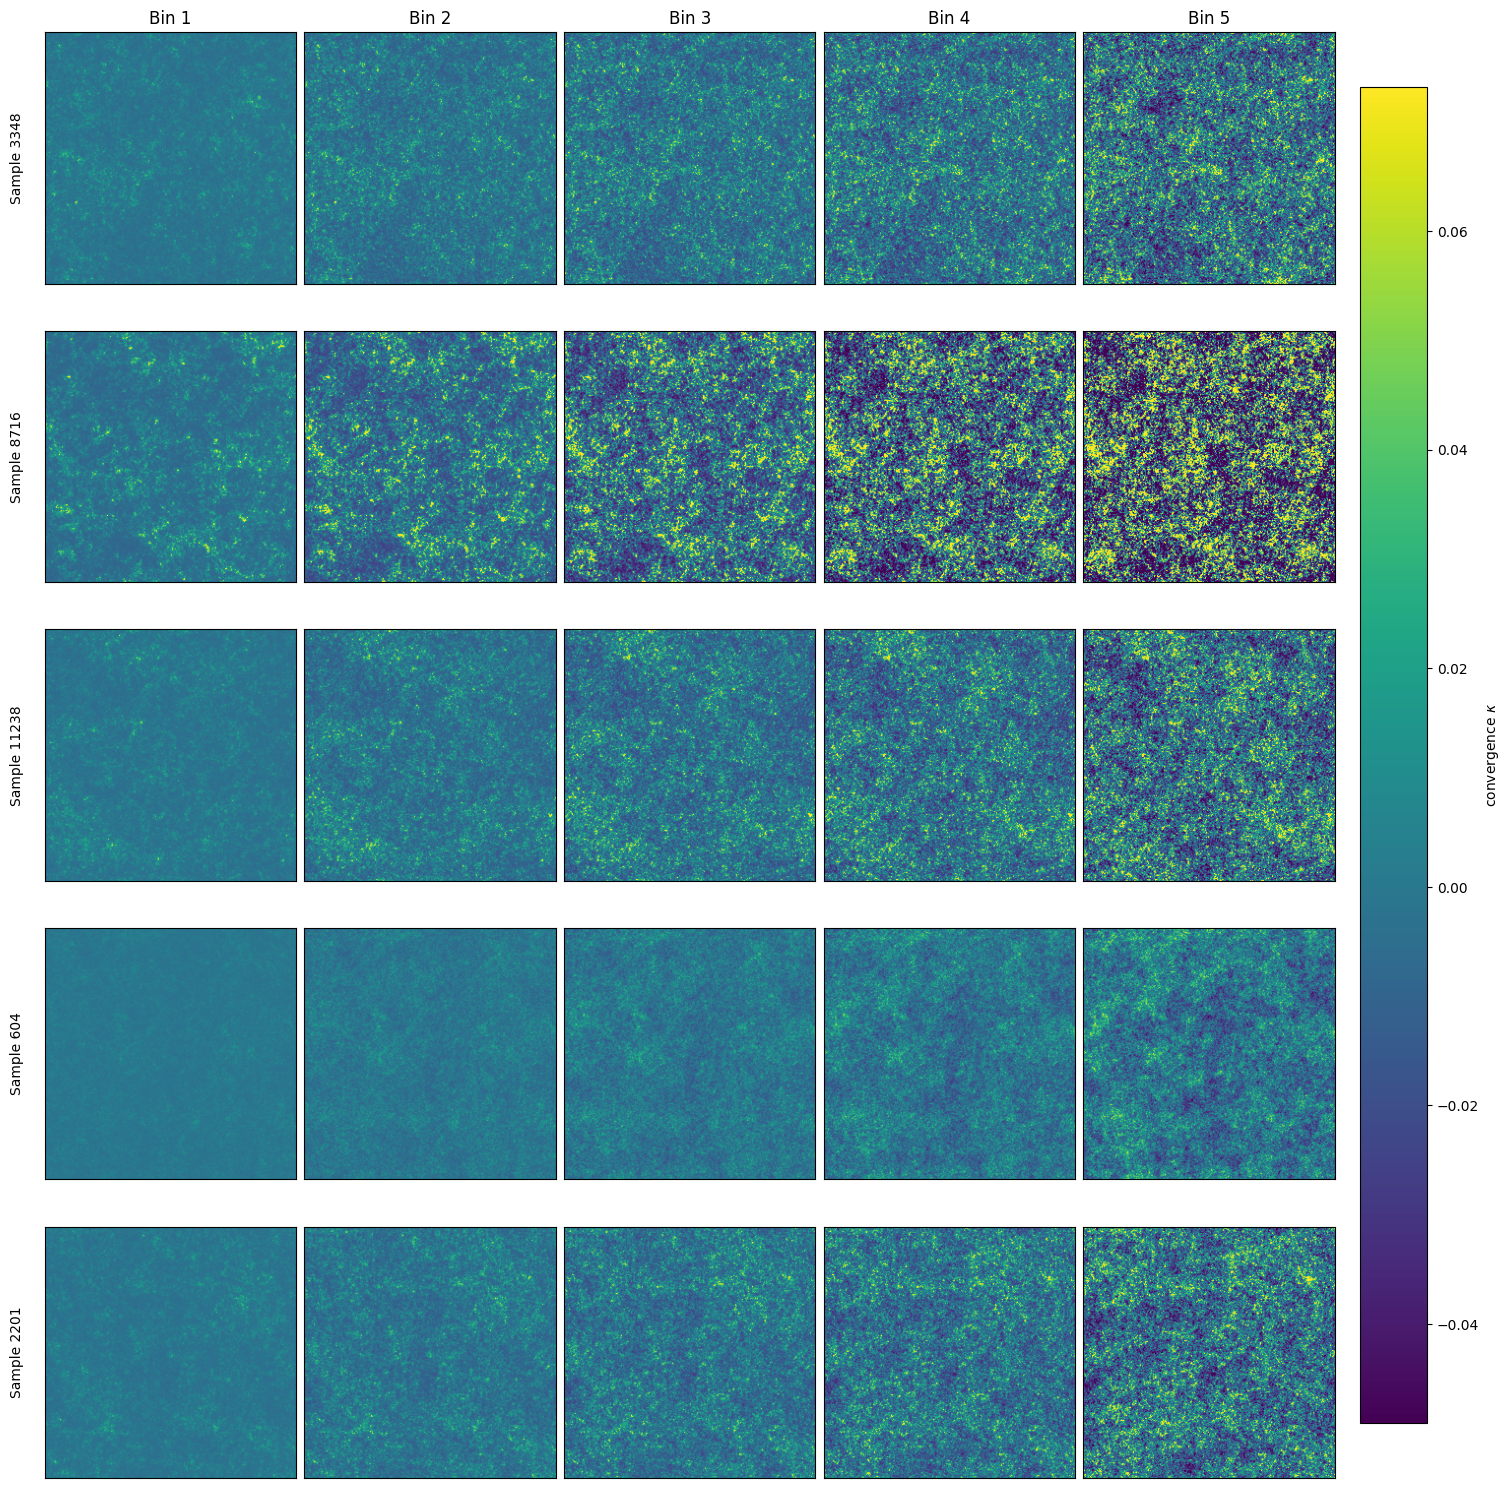

In [8]:
import numpy as np

n_rows = 5

idxs = torch.randperm(maps.shape[0])[:n_rows].tolist()

maps_cpu = maps.detach().cpu()

subset = maps_cpu[idxs]
vmin = np.percentile(subset.numpy(), 1)
vmax = np.percentile(subset.numpy(), 99)

fig, axes = plt.subplots(n_rows, 5, figsize=(15, 15), constrained_layout=True)

for r, idx in enumerate(idxs):
    for z in range(5):
        ax = axes[r, z]
        img = maps_cpu[idx, :, :, z].numpy()
        im = ax.imshow(img, origin="lower", vmin=vmin, vmax=vmax)
        ax.set_xticks([])
        ax.set_yticks([])
        if r == 0:
            ax.set_title(f"Bin {z+1}")
    axes[r, 0].set_ylabel(f"Sample {idx}", labelpad=20, va="center")

cbar = fig.colorbar(im, ax=axes, shrink=0.9, pad=0.02)
cbar.set_label(r"convergence $\kappa$")

plt.show()

Plot histograms for all six cosmological parameters. The order of the parameters in `params` is `omega_c`, `omega_b`, `sigma_8`, `h_0`, `n_s`, `w_0`; label the histograms accordingly. You'll want to use `plt.hist()`.

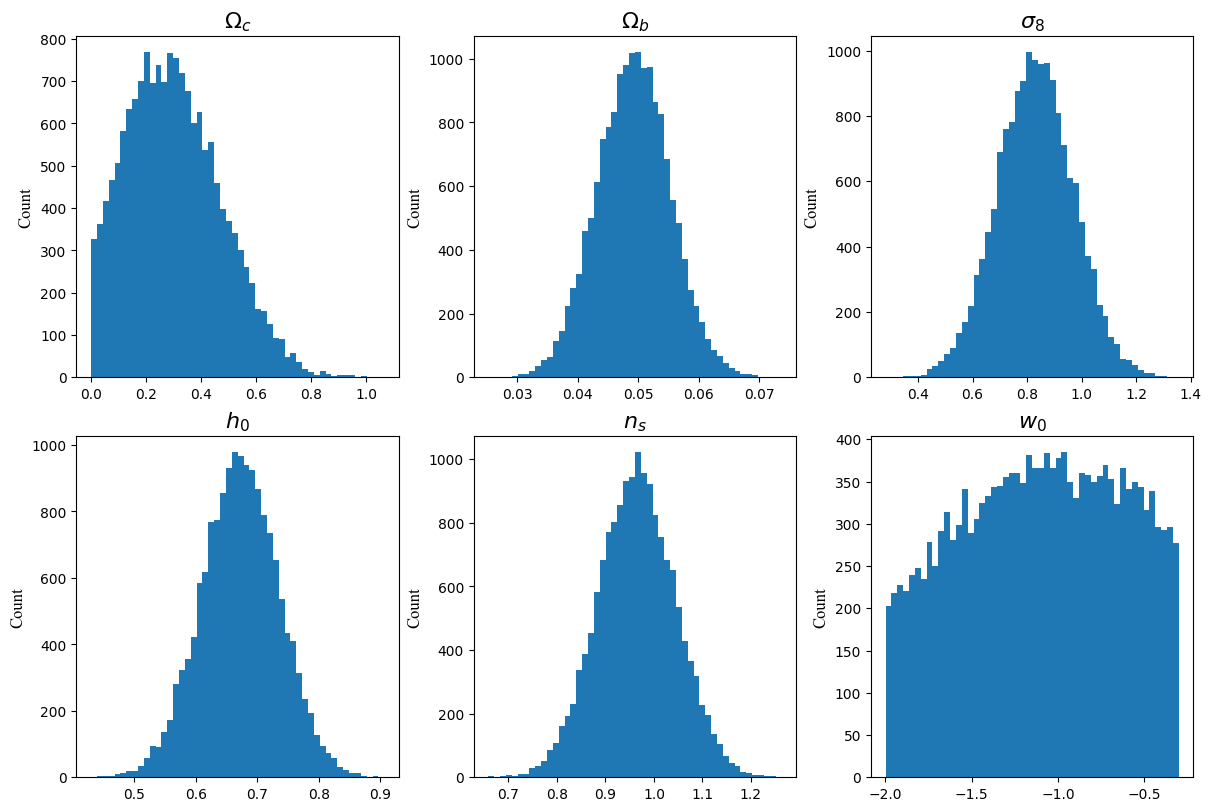

In [9]:
names = [r"$\Omega_c$", r"$\Omega_b$", r"$\sigma_8$", r"$h_0$", r"$n_s$", r"$w_0$"]

params_cpu = params.detach().cpu()

fig, axes = plt.subplots(2, 3, figsize=(12, 8), constrained_layout=True)
axes = axes.ravel()

for j, name in enumerate(names):
    ax = axes[j]
    x = params_cpu[:, j].numpy()
    ax.hist(x, bins=50)
    ax.set_title(name, fontfamily="Times New Roman", fontsize=16, fontweight="bold")
    ax.set_ylabel("Count", fontfamily="Times New Roman", fontsize=12)

plt.show()


Do the maps have any obvious traits for different values of the cosmological parameters? For example, do maps with large $\sigma_8$ look "clumpier" than those with small $\sigma_8$?

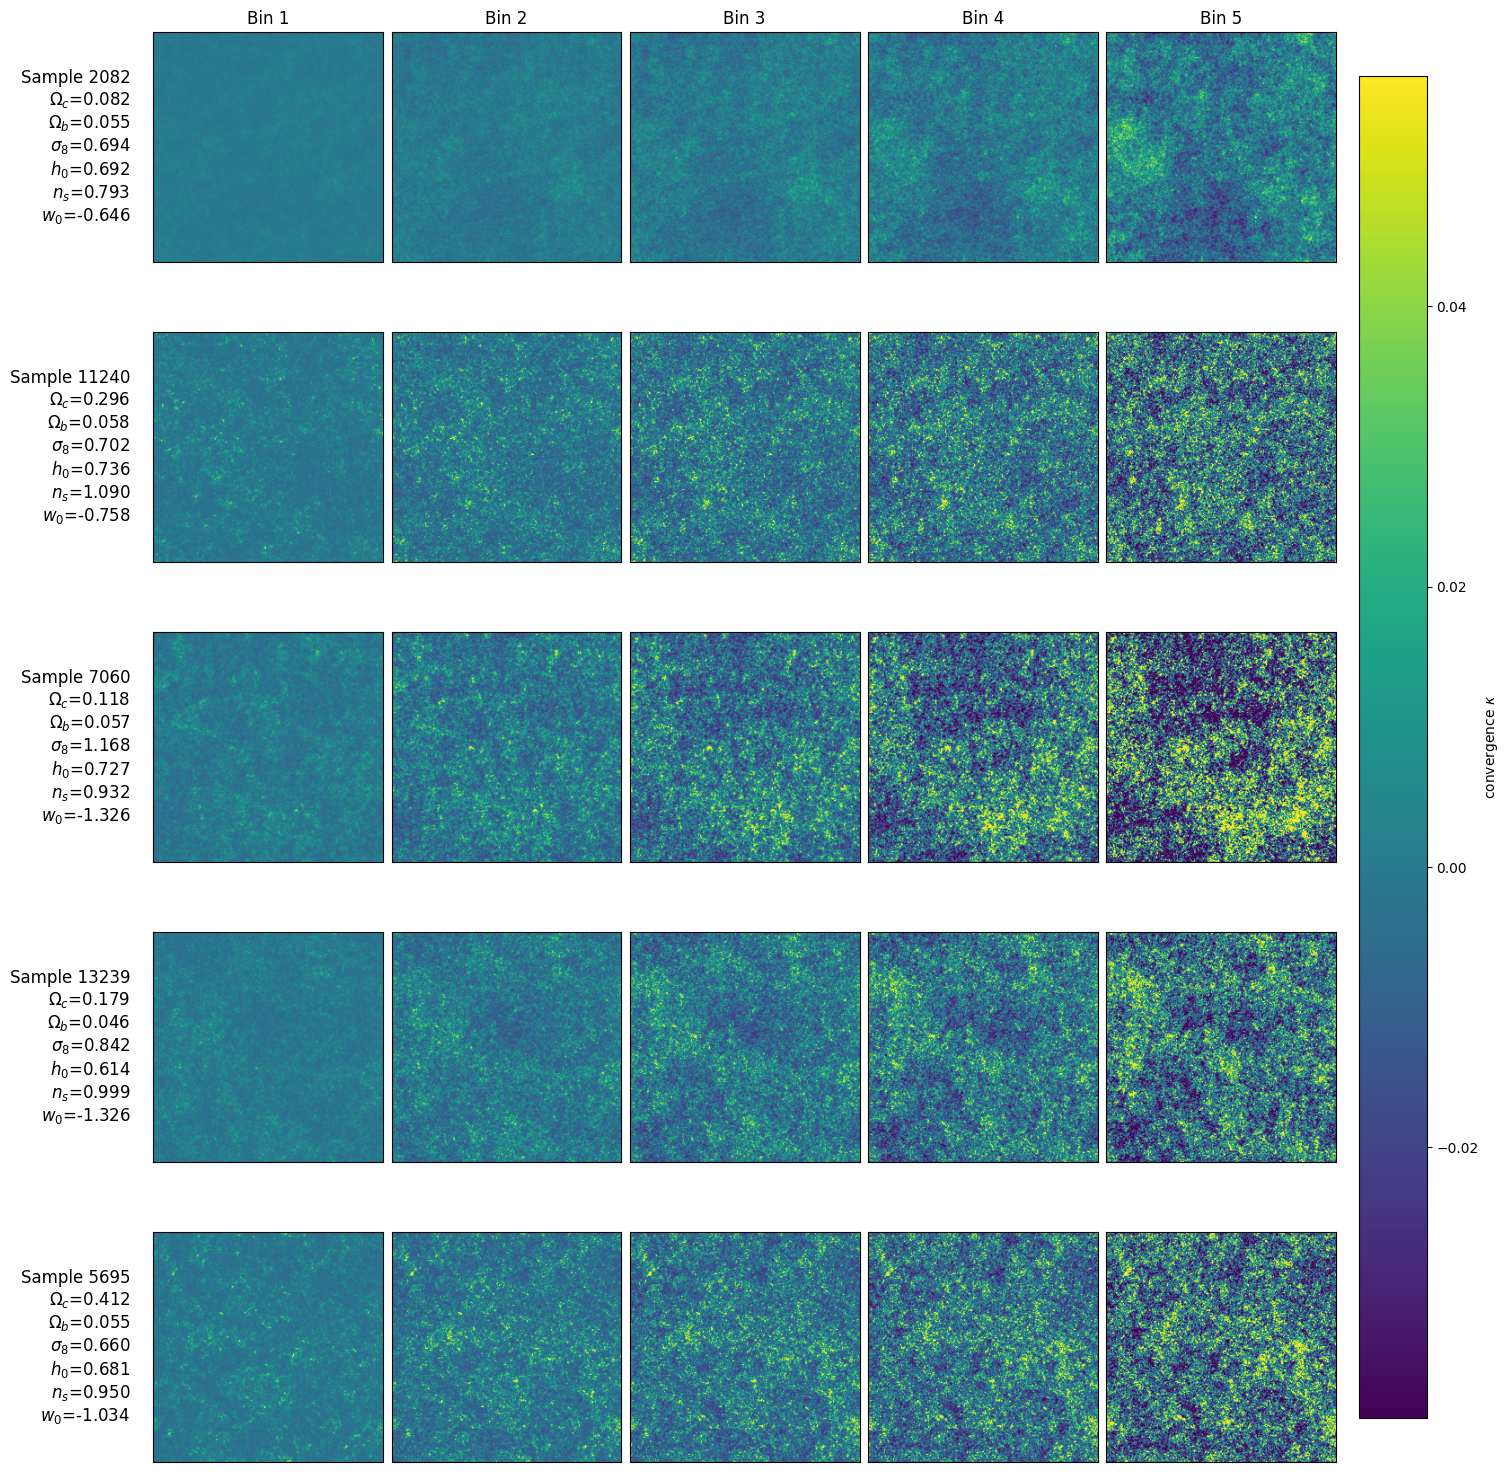

In [10]:
import numpy as np

n_rows = 5
idxs = torch.randperm(maps.shape[0])[:n_rows].tolist()

maps_cpu = maps.detach().cpu()
params_cpu = params.detach().cpu()

subset = maps_cpu[idxs]
vmin = np.percentile(subset.numpy(), 1)
vmax = np.percentile(subset.numpy(), 99)

fig, axes = plt.subplots(n_rows, 5, figsize=(15, 15), constrained_layout=True)

for r, idx in enumerate(idxs):
    Omega_c, Omega_b, sigma8, h0, ns, w0 = params_cpu[idx].tolist()

    param_text = (
        f"Sample {idx}\n"
        + r"$\Omega_c$" + f"={Omega_c:.3f}\n"
        + r"$\Omega_b$" + f"={Omega_b:.3f}\n"
        + r"$\sigma_8$" + f"={sigma8:.3f}\n"
        + r"$h_0$"      + f"={h0:.3f}\n"
        + r"$n_s$"      + f"={ns:.3f}\n"
        + r"$w_0$"      + f"={w0:.3f}"
    )

    for z in range(5):
        ax = axes[r, z]
        img = maps_cpu[idx, :, :, z].numpy()
        im = ax.imshow(img, origin="lower", vmin=vmin, vmax=vmax)
        ax.set_xticks([])
        ax.set_yticks([])
        if r == 0:
            ax.set_title(f"Bin {z+1}")

    axes[r, 0].text(
        -0.1, 0.5, param_text,
        transform=axes[r, 0].transAxes,
        ha="right", va="center",
        fontsize=12
    )

cbar = fig.colorbar(im, ax=axes, shrink=0.9, pad=0.02)
cbar.set_label(r"convergence $\kappa$")

plt.show()



The maps do have traits for different values of the cosmological parameters.
Maps with large $\sigma_8$ look "clumpier" than those with small $\sigma_8$. Maps with large sum of $\sigma_c$ and $\sigma_b$ are more convergent.